## Оптимальное назначение состава генерирующего оборудования АГЭК на двое суток вперед

### 1. Загрузка модулей

In [1]:
import matplotlib.pyplot as plt
import pvlib
import math
import pandas as pd
import numpy as np
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import pypsa
import sys
from pyomo.environ import *

### 2. Загрузка исходных данных 

Задаем местоположение СДК

In [2]:
location = pvlib.location.Location(67.5538, 133.38976, tz='Asia/Vladivostok', altitude=137, name='Verkhoyansk')

Загружаем график нагрузки

In [3]:
Load0 = pd.read_csv('Load.csv', sep=';')
Load = Load0.Load
#Load.to_excel('Demand.xls')

In [4]:
poa=pd.read_csv('poa_irr.csv') #index_col=0, #parse_dates=True)
poa_global = poa.poa_global

### 3. Выбор состава генерирующего оборудования 

Задача оптимизации состава генерирующего оборудования является проблемой частично-целочисленного программирования (то есть искомые нами параметры могут относиться как к классу дискретных целых (integers) и бинарных (binary) величин, так и к непрерывным (continuous). В связи с этим использование таких распространенных методов стохастической оптимизации, как метод роя частиц или муравьиный алгоритм, затруднено (нужны их модификации).

Для частично-целочисленного программирования далее используется бесплатная библиотека pyomo 
Модель микросети сформулирована при помощи бесплатной библиотеки pyPSA 

In [6]:
nu = pypsa.Network() #инициация объекта сети

tt1=0 #1300-1400
tt2=1400

nu.set_snapshots(range(tt1,tt2)) #временные интервалы

nu.add("Bus", "AC") #добавление шины AC к сети

nu.add("Bus", "DC1") #добавление шины DC к сети

nu.add("Bus", "DC2") #добавление шины DC к сети

nu.add("Carrier", "diesel") #первичные энергоресурсы (для встроенного в pyPSA расчета выбросов CO2 - это пока не нужно)
nu.add("Carrier","solar")
nu.add("Carrier","battery")


#величины капитальных и эксплуатационных затрат на оборудование пока указаны для примера 

nu.add("Generator","diesel1", #добавление ДГУ
       bus="AC", #шина подключения AC
       committable=True, #возможность диспетчеризации
       capital_cost=300, #удельные кап. затраты, у.е./МВт
       marginal_cost=11, #эксплуатационные затраты, у.е./МВт*ч
       p_min_pu=0.75, #ограничение по минимальной мощности в долях от 1
       p_nom_extendable=False, #оптимизация режима с заданным p_ном; if True: оптимизация номинальной мощности
       p_nom=0.320, #номинальная мощность ДГУ, МВт
       efficiency = 0.9, #КПД
       min_up_time = 3, #минимальное число работы генератора в интервалах (например, в часах)
       min_down_time = 3, #минимальное число работы генератора в интервалах (например, в часах)
       up_time_before = 0,
       down_time_before = 0,
       start_up_cost = 8, #затраты на холодный старт генератора в у.е
       shut_down_cost = 0, #затраты на отключение генератора в у.е
       ramp_limit_start_up = 0) #ограничение набора нагрузки за период между заданными интервалами в долях от ном. мощности
       #ramp_limit_down = None, #ограничение сброса нагрузки за период между заданными интервалами в долях от ном. мощности
       #ramp_limit_start_up = 1) #ограничение набора нагрузки в момент пуска в долях от ном. мощности

nu.add("Generator","diesel2",bus="AC",
       committable=True,
       capital_cost=300,
       marginal_cost=15,
       efficiency = 0.9, #КПД
       p_min_pu=0.75,
       p_nom_extendable=False,
       p_nom=0.320,
       min_up_time = 3,
       min_down_time = 3,
       up_time_before = 0,
       down_time_before = 0,
       start_up_cost = 8,
       shut_down_cost = 0,
       ramp_limit_start_up = 0.1)

nu.add("Generator","diesel3",bus="AC",
       committable=True,
       capital_cost=300,
       marginal_cost=15,
       efficiency = 0.9, #КПД
       p_min_pu=0.5,
       p_nom_extendable=False,
       p_nom=0.520,
       min_up_time = 3,
       min_down_time = 3,
       up_time_before = 0,
       down_time_before = 0,
       start_up_cost = 8,
       shut_down_cost = 0)

nu.add("Generator","diesel4",bus="AC",
       committable=True,
       capital_cost=300,
       marginal_cost=15,
       efficiency = 0.9, #КПД
       p_min_pu=0.5,
       p_nom_extendable=False,
       p_nom=0.520,
       min_up_time = 3,
       min_down_time = 3,
       up_time_before = 0,
       down_time_before = 0,
       start_up_cost = 8,
       shut_down_cost = 0)



nu.add("Generator","solar1",bus="AC", #добавление массива ФЭМ 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)


nu.add("Generator","solar2",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)


nu.add("Generator","solar3",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)

nu.add("Generator","solar4",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)

nu.add("Generator","solar5",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)

nu.add("Generator","solar6",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)

nu.add("Generator","solar7",bus="AC", 
       committable=True,
       marginal_cost=0.3,
       p_min_pu=0,
       p_max_pu=(poa_global/poa_global.max())[tt1:tt2], #максимальная мощность в долях от номинальной
       p_nom = 0.136, # мощность PV, МВт
       p_nom_extendable=False,
       efficiency=0.2,
       capital_cost=3600,start_up_cost = -5, shut_down_cost=-5)


#добавление нагрузки
nu.add("Load","load",bus="AC",p_set=Load[tt1:tt2]/1000)

#двунаправленный инвертор задаем через два отдельных компонента link - один для заряда, другой для разряда СНЭ

nu.add("Link",
name ="Inverter1 DC2AC",
bus0="DC1",
bus1="AC",
p_nom=0.150, #номинальная зарядная мощность
p_nom_extendable=False,
marginal_cost=10)

nu.add("Link",
name ="Inverter1 AC2DC",
bus0="AC",
bus1="DC1",
p_nom=0.165, #номинальная разрядная мощность
p_nom_extendable=False)

nu.add("Link",
name ="Inverter2 DC2AC",
bus0="DC2",
bus1="AC",
p_nom=0.150, #номинальная зарядная мощность
p_nom_extendable=False,
marginal_cost=10)

nu.add("Link",
name ="Inverter2 AC2DC",
bus0="AC",
bus1="DC2",
p_nom=0.165, #номинальная разрядная мощность
p_nom_extendable=False)

#добавляем СНЭ1 
nu.add("Store",
name="Battery Storage 1",
bus="DC1",
e_nom=0.7, #номинальная емкость СНЭ в МВтч
e_nom_extendable=False,
e_min_pu=0.3, #минимальная допустимая емкость СНЭ в долях от номинальной
e_initial = 0.3, #емкость СНЭ до начала расчета
standing_loss = 0.0001, #коэффициент саморазряда
capital_cost=1000,
marginal_cost=10)

#добавляем СНЭ2 
nu.add("Store",
name="Battery Storage 2",
bus="DC2",
e_nom=0.7, #номинальная емкость СНЭ в МВтч
e_nom_extendable=False,
e_min_pu=0.3, #минимальная допустимая емкость СНЭ в долях от номинальной
e_initial = 0.3, #емкость СНЭ до начала расчета
standing_loss = 0.0001, #коэффициент саморазряда
capital_cost=1000,
marginal_cost=10)


#solver glpk надо вручную добавлять в path. После перезапуска ядра должно работать (по крайней мере на Linux все ОК, а на Windows вообще не поставился).
#solver cbc на Linux на Windows устанавливается только руками - надо скачать binary files с сайта https://projects.coin-or.org/Cbc/browser/releases/2.8.1/INSTALL 
#после чего исполняемые .exe файлы необходимо поместить в директорию your_venv\anaconda3\Library\bin и перезапустить ядро 


nu.consistency_check()

def extra_functionality(network,snapshots):

        
        #Guarantees heat output and electric output nominal powers are proportional
        network.model.chp_nom = Constraint(rule=lambda model : network.links.at["generator","efficiency"]*nom_r*model.link_p_nom["generator"] == network.links.at["boiler","efficiency"]*model.link_p_nom["boiler"])

        #Guarantees c_m p_b1  \leq p_g1
        def backpressure(model,snapshot):
            return c_m*network.links.at["boiler","efficiency"]*model.link_p["boiler",snapshot] <= network.links.at["generator","efficiency"]*model.link_p["generator",snapshot] 
        
        network.model.backpressure = Constraint(list(snapshots),rule=backpressure)
        
        #Guarantees p_g1 +c_v p_b1 \leq p_g1_nom
        def top_iso_fuel_line(model,snapshot):
            return model.link_p["boiler",snapshot] + model.link_p["generator",snapshot] <= model.link_p_nom["generator"]
        
        network.model.top_iso_fuel_line = Constraint(list(snapshots),rule=top_iso_fuel_line)

Index(['min_up_time', 'min_down_time', 'up_time_before', 'down_time_before'], dtype='object', name='attribute')
They are:
attribute
min_up_time         int64
min_down_time       int64
up_time_before      int64
down_time_before    int64
dtype: object
but should be:
attribute
min_up_time         int32
min_down_time       int32
up_time_before      int32
down_time_before    int32
Name: dtype, dtype: object


In [9]:
#C:\Users\Narynbaev\anaconda3\pkgs\pyomo-5.7.3-py38h885f38d_0\Lib\site-packages\pyomo\solvers\plugins\solvers

In [7]:
start_time = time.time()
nu.lopf(nu.snapshots, pyomo=True, solver_name='scipampl',solver_logfile='logfile.txt')
       #solver_options={'sec':'560', 'Tee':'True', 'fracGap':'1'}) #,extra_functionality=extra_functionality)
print("TIME:::: --- %s seconds ---" % (time.time() - start_time))

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using asl
ERROR:pyomo.opt:Solver (asl) returned non-zero return code (1)
ERROR:pyomo.opt:Solver log:
SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  bliss 0.73p          Computing Graph Automorphism Groups by T. Junttila and P. Kaski (http://www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.13.1         Interior Point Optimizer developed by A. Waechter et.al. (www.coin-or.org/Ipopt)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.

ApplicationError: Solver (asl) did not exit normally

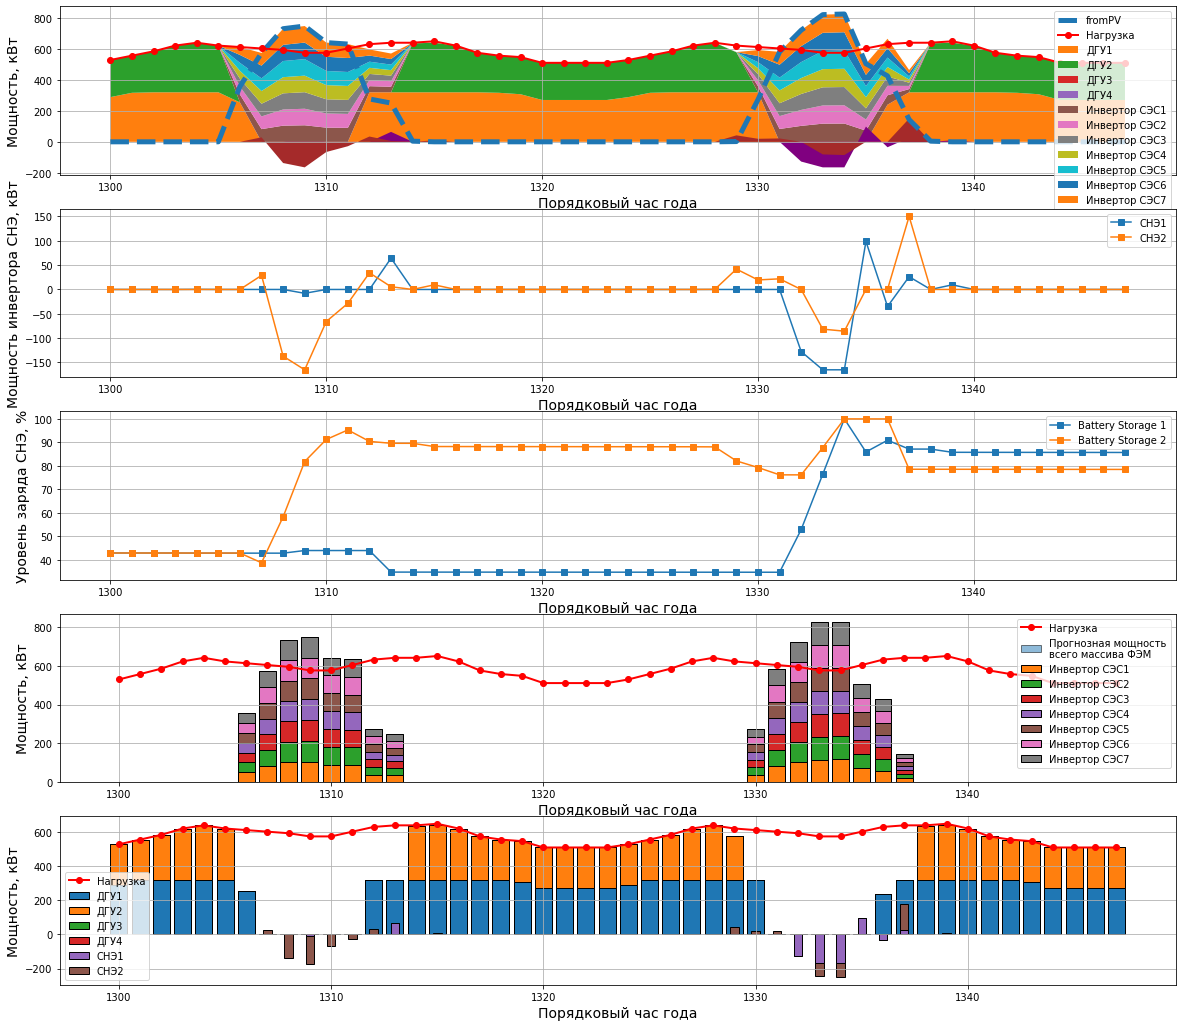

In [7]:
#графики

t1 = 0
t2 = 48

fig, ax = plt.subplots(5, figsize=(20, 18))
#(nu.generators_t.p*1000)[t1:t2].plot(ax=ax[0],marker='^')
ax[0].plot((Load[tt1:tt2]).index[t1:t2], 952*(poa_global/poa_global.max())[tt1:tt2][t1:t2], '--',label='fromPV', linewidth=5)
(nu.stores_t.e/nu.stores.e_nom_opt*100)[t1:t2].plot(ax=ax[2], marker='s')
#ax[3].plot((Load[tt1:tt2]).index[t1:t2], Load[tt1:tt2][t1:t2], label='Load', marker='o')
ax[1].plot((Load[tt1:tt2]).index[t1:t2], (nu.stores_t.p['Battery Storage 1']*1000)[t1:t2], label='СНЭ1', marker='s')
ax[1].plot((Load[tt1:tt2]).index[t1:t2], (nu.stores_t.p['Battery Storage 2']*1000)[t1:t2], label='СНЭ2', marker='s')
ax[0].set_xlabel('Порядковый час года', fontsize=14)
ax[0].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[1].set_xlabel('Порядковый час года', fontsize=14)
ax[1].set_ylabel('Мощность инвертора СНЭ, кВт', fontsize=14)
ax[2].set_xlabel('Порядковый час года', fontsize=14)
ax[2].set_ylabel('Уровень заряда СНЭ, %', fontsize=14)

ax[3].set_xlabel('Порядковый час года', fontsize=14)
ax[3].set_ylabel('Мощность, кВт', fontsize=14)
#ax[1].plot(nu.stores_t.p.index[t1:t2], (nu.stores_t.p*1000)[t1:t2], label = 'Storage')
ax[4].set_xlabel('Порядковый час года', fontsize=14)
ax[4].set_ylabel('Мощность, кВт', fontsize=14)


#ax[1].plot(poa.index, tmy['ghi'], label = 'GHI')
ax[1].legend(loc='best')
ax[0].legend(loc='best')



ax[0].plot((Load[tt1:tt2]).index[t1:t2], Load[tt1:tt2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)

labels = ["ДГУ1", "ДГУ2", "ДГУ3", "ДГУ4", "Инвертор СЭС1", "Инвертор СЭС2", "Инвертор СЭС3", "Инвертор СЭС4",
         "Инвертор СЭС5", "Инвертор СЭС6", "Инвертор СЭС7"]

ax[0].stackplot((Load[tt1:tt2]).index[t1:t2], (nu.generators_t.p['diesel1']*1000)[t1:t2],
                (nu.generators_t.p['diesel2']*1000)[t1:t2],(nu.generators_t.p['diesel3']*1000)[t1:t2],
                (nu.generators_t.p['diesel4']*1000)[t1:t2],
                (nu.generators_t.p['solar1']*1000)[t1:t2],(nu.generators_t.p['solar2']*1000)[t1:t2],
                (nu.generators_t.p['solar3']*1000)[t1:t2],(nu.generators_t.p['solar4']*1000)[t1:t2],
                (nu.generators_t.p['solar5']*1000)[t1:t2],(nu.generators_t.p['solar6']*1000)[t1:t2],
                (nu.generators_t.p['solar7']*1000)[t1:t2],
               baseline ='zero', labels=labels) #labels=labels
ax[0].stackplot((Load[tt1:tt2]).index[t1:t2], (nu.stores_t.p['Battery Storage 1']*1000)[t1:t2],
               baseline ='zero', colors = ['purple'],labels=['СНЭ1'])
ax[0].stackplot((Load[tt1:tt2]).index[t1:t2], (nu.stores_t.p['Battery Storage 2']*1000)[t1:t2],
               baseline ='zero', colors =['brown'], labels=['СНЭ2'])


#colors =['orange', 'blue', 'green']




ax[3].bar((Load[tt1:tt2]).index[t1:t2], 952*(poa_global/poa_global.max())[tt1:tt2][t1:t2], 
          label='Прогнозная мощность\nвсего массива ФЭМ', alpha=0.5, edgecolor = "black")
ax[3].plot((Load[tt1:tt2]).index[t1:t2], Load[tt1:tt2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar1']*1000)[t1:t2], label='Инвертор СЭС1', edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar2']*1000)[t1:t2], label='Инвертор СЭС2',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2], edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar3']*1000)[t1:t2], label='Инвертор СЭС3',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2]+(nu.generators_t.p['solar2']*1000)[t1:t2],
         edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar4']*1000)[t1:t2], label='Инвертор СЭС4',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2]+(nu.generators_t.p['solar2']*1000)[t1:t2]+
          (nu.generators_t.p['solar3']*1000)[t1:t2], edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar5']*1000)[t1:t2], label='Инвертор СЭС5',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2]+(nu.generators_t.p['solar2']*1000)[t1:t2]+
          (nu.generators_t.p['solar3']*1000)[t1:t2]+(nu.generators_t.p['solar4']*1000)[t1:t2],
         edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar6']*1000)[t1:t2], label='Инвертор СЭС6',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2]+(nu.generators_t.p['solar2']*1000)[t1:t2]+
          (nu.generators_t.p['solar3']*1000)[t1:t2]+(nu.generators_t.p['solar4']*1000)[t1:t2]+
          (nu.generators_t.p['solar5']*1000)[t1:t2], edgecolor = "black")
ax[3].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['solar7']*1000)[t1:t2], label='Инвертор СЭС7',
         bottom=(nu.generators_t.p['solar1']*1000)[t1:t2]+(nu.generators_t.p['solar2']*1000)[t1:t2]+
          (nu.generators_t.p['solar3']*1000)[t1:t2]+(nu.generators_t.p['solar4']*1000)[t1:t2]+
          (nu.generators_t.p['solar5']*1000)[t1:t2]+(nu.generators_t.p['solar6']*1000)[t1:t2],
         edgecolor = "black")


ax[4].plot((Load[tt1:tt2]).index[t1:t2], Load[tt1:tt2][t1:t2], label='Нагрузка', marker='o', color='red', linewidth=2)
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['diesel1']*1000)[t1:t2], label='ДГУ1', edgecolor = "black")
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['diesel2']*1000)[t1:t2], label='ДГУ2',
         bottom=(nu.generators_t.p['diesel1']*1000)[t1:t2], edgecolor = "black")
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['diesel3']*1000)[t1:t2], label='ДГУ3', edgecolor = "black",
         bottom=(nu.generators_t.p['diesel1']*1000)[t1:t2]+(nu.generators_t.p['diesel2']*1000)[t1:t2])
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.generators_t.p['diesel4']*1000)[t1:t2], label='ДГУ4',
         bottom=(nu.generators_t.p['diesel1']*1000)[t1:t2]+(nu.generators_t.p['diesel2']*1000)[t1:t2]+
          +(nu.generators_t.p['diesel3']*1000)[t1:t2],
          edgecolor = "black")
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2], label='СНЭ1',
         edgecolor = "black", width=0.4)
ax[4].bar((Load[tt1:tt2]).index[t1:t2],(nu.stores_t.p['Battery Storage 2']*1000)[t1:t2], label='СНЭ2',
         bottom=(nu.stores_t.p['Battery Storage 1']*1000)[t1:t2],
          edgecolor = "black", width=0.4)



ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
ax[4].grid()
ax[0].legend(loc='best')
ax[3].legend(loc='best')
ax[4].legend(loc='best')

plt.show()

In [9]:
nu.stores

attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt
Battery Storage 1,DC1,,0.7,False,0.0,inf,0.3,1.0,0.3,False,0.0,0.0,1.0,10.0,1000.0,0.0001,0.7
Battery Storage 2,DC2,,0.7,False,0.0,inf,0.3,1.0,0.3,False,0.0,0.0,1.0,10.0,1000.0,0.0001,0.7


In [10]:
nu.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
diesel1,AC,Slack,,0.320,False,0.0,inf,0.75,1.0,0.0,...,0.0,3,3,0,0,NaN,NaN,0.0,1.0,0.320
diesel2,AC,PQ,,0.320,False,0.0,inf,0.75,1.0,0.0,...,0.0,3,3,0,0,NaN,NaN,0.1,1.0,0.320
diesel3,AC,PQ,,0.520,False,0.0,inf,0.50,1.0,0.0,...,0.0,3,3,0,0,NaN,NaN,1.0,1.0,0.520
diesel4,AC,PQ,,0.520,False,0.0,inf,0.50,1.0,0.0,...,0.0,3,3,0,0,NaN,NaN,1.0,1.0,0.520
solar1,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136
solar2,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136
solar3,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136
solar4,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136
solar5,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136
solar6,AC,PQ,,0.136,False,0.0,inf,0.00,1.0,0.0,...,-5.0,0,0,1,0,NaN,NaN,1.0,1.0,0.136


In [13]:
nu.links

attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
Inverter1 DC2AC,DC1,AC,,1.0,0.150,False,0.0,inf,0.0,0.0,1.0,0.0,10.0,0.0,1.0,0.150
Inverter1 AC2DC,AC,DC1,,1.0,0.165,False,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.165
Inverter2 DC2AC,DC2,AC,,1.0,0.150,False,0.0,inf,0.0,0.0,1.0,0.0,10.0,0.0,1.0,0.150
Inverter2 AC2DC,AC,DC2,,1.0,0.165,False,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.165


In [14]:
nu.model.objective()

615.0759978613214

In [15]:
(2923.5*(nu.generators_t.p)**4 - 7291*(nu.generators_t.p)**3 + 6449.6*(nu.generators_t.p)**2 - 2389.9*nu.generators_t.p + 582.94).sum()[1]+(2923.5*(nu.generators_t.p)**4 - 7291*(nu.generators_t.p)**3 + 6449.6*(nu.generators_t.p)**2 - 2389.9*nu.generators_t.p + 582.94).sum()[0]

72457.8411824317

In [16]:
nu.generators_t.status[0:50].merge(nu.generators_t.p[0:50])

,diesel1,diesel2,diesel3,diesel4,solar1,solar2,solar3,solar4,solar5,solar6,solar7


In [18]:
table = pd.concat([nu.generators_t.status, nu.generators_t.p, nu.stores_t.p], axis=1)[50:100]